# QOSF Mentorship Screening Task 2


### Author
Tony Tong 

## Question
Task 2
Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

### Bonus
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

## Answer Summary

### Introduction
In a general 2-qubit system
$$\big|\psi\rangle=\alpha\big|00\rangle+\beta\big|01\rangle+\gamma\big|10\rangle+\delta\big|11\rangle$$

$$\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$$


So in order to satisfy $\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$:

$$q_1 = \big| 0 \rangle, q_2 = \big| 1 \rangle$$ $$q_1 = \big| 1 \rangle, q_2 = \big| 1 \rangle$$

When measuring in Z basis:
$$\langle 0\big| \sigma_z  \big| 0 \rangle = 1$$
$$\langle 1\big| \sigma_z  \big| 1 \rangle = -1$$


### Parametrized Models
Three parametrized quantum circuits (PQC) with different optimization methods, namely Rotosolve, Rotoselect [1] and QGAN [2], will be explored.

#### Rotosolve
Rotosolve will optimize a given parameters for a given circuit ansatz. The circuit ansatz chosen is made of 2 layers of single qubit Pauli-Y/X rotation and a CNOT block to entangle the 2 qubits so that it is expressible enough while having resonable noise.

The actual algorithm takes the advantage of the fact that the expectation value as a function of an angle of rotation has sinusoidal form. When optimizing, it finds the optimal angle for one gate when fixing all the others to the current value [1]. For a certain gate, the optimal angle has a closed form expression:

$$\begin{aligned}
\theta_{d}^{*} &=\arg \min _{\theta_{d}}\langle M\rangle_{\theta_{d}} \\
&=\phi-\frac{\pi}{2}-\arctan 2\left(2\langle M\rangle_{\theta_{d}=\phi}-\langle M\rangle_{\theta_{d}=\phi+\frac{\pi}{2}}-\langle M\rangle_{\theta_{d}=\phi-\frac{\pi}{2}}, \quad\langle M\rangle_{\theta_{d}=\phi+\frac{\pi}{2}}-\langle M\rangle_{\theta_{d}=\phi-\frac{\pi}{2}}\right)+2 \pi k
\end{aligned}$$

#### Rotoselect
Rotoselect builds on the Rotosolve algorithm, now the choice of the parametric gates themselves (Rx, Ry in our case) can also be optimized.

##### Loss fucntion for Rotosolve and Rotoselect
Since $q_1, q_2$ cancels each other in Z basis, we can choose our loss function for the opimizing algorithms:
$$L = \big|\langle q_1\big| \sigma_z  \big| q_1 \rangle + \langle q_2\big| \sigma_z  \big| q_2 \rangle\big|$$

#### QGAN
A quantum Generative Adversarial Network (qGAN) can learn the distribution of a particular smaple and load it into a quantum state [2].  

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$. In our general two qubit system:

$$\big|\psi\rangle=\alpha\big|00\rangle+\beta\big|01\rangle+\gamma\big|10\rangle+\delta\big|11\rangle$$

where $\big| j\rangle\in \left\{\big|00\rangle, \big|01\rangle, \big|10\rangle, \big|11\rangle\right\}$.

So our goal is to train a quantum generator that can generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j} = 0.5$ if $\big| j\rangle \in \left\{\big|01\rangle, \big|10\rangle\right\}$.

As a result, the training data should follow a bimodal distribution where the two peaks is around $\big|01\rangle, \big|10\rangle$. It is worth noting that a GAN is well suited for generate both uni-modal and multi-modal distributions.

The qGAN in our case is made of two layers of $R_y$ gates and a CNOT gate in the middle for entanglement. The circuit diagram can be found below in the qGAN section.

##### Loss fucntion for qGAN
For the quantum generator:
$$L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right]$$
and for the classical discriminator:
$$L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right]$$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

We can intuitively see that the generator would like to generate a state which cannot be distinguished by the discriminator.

### Metric
To evaluate the stability and accuracy of the models with different optimization methods, two metrics will be used:
1. The standard deviation of loss after 10 iterations
2. Mean squared error = $\frac{1}{2}[(\left|\beta\right|^{2} - 0.5)^2 + (\left|\gamma\right|^{2} - 0.5)^2]$

Note the second metric access the information in the state vector directly and thus is only possible to get in simulation.

Also, for qGAN, we only use MSE to evaluate its accuarcy. The stability of qGAN can be found in its loss plot.


### Result
Both Rotosovle and Rotoselect has decent accuracy (MSE < 0.012) with 1000 measurements. Also, they tend to optimize fairly quickly within a few iterations, which is better than gradient descent. On the other hand, in my experiements, Rotoselect's metrics behave similarly as Rotosolve's with respect to the numebr of measurements. Also note that Rotoselect's performance is about the same as Rotosolve's probably because that the circuit is simple. In fact in Fig.2 in the original paper [1], when working on VQE to minimize the energy, the Rotoseletct performs consistently better when the number of layers in the circuit is larger than 4.

qGAN also has decent accuracy (MSE=0.078). Both generator's and discriminator's losses are stable after ~100 iterations. Comparing to Rotosolve and Rotoselect, qGAN generates larger probabilities for $\big|00\rangle, \big|01\rangle$, probably becasue the training dataset, the bi-modal distribution built with two normal distribution has non-zero value in those region. If the standard deviation for the two normal distributions are made smaller, the qGAN might be able to produce better result.

The qGAN's performance might improve with a larger dataset and longer training time, but the training takes a long time. If time permits, more optimization and hyperparameter search should be tried. Also, it might be interesting to take advantage of GPU for the training.

### References
[1] M. Ostaszewski, E. Grant, and M. Benedetti, Quantum Circuit Structure Learning, ArXiv:1905.09692 [Quant-Ph] (2019).

[2] C. Zoufal, A. Lucchi, and S. Woerner, Quantum Generative Adversarial Networks for Learning and Loading Random Distributions, Npj Quantum Inf 5, 103 (2019).

In [126]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import truncnorm

n_wires = 2

dev = qml.device("default.qubit", wires=2)

### Rotosolve
Rotosolve will optimize a given parameters for a given circuit ansatz. The circuit ansatz chosen is made of 2 layers of single qubit Pauli-Y/X rotation and a CNOT block to entangle the 2 qubits so that it is expressible enough while having resonable noise.

In [127]:
def opt_theta(d, params, cost):
    params[d] = 0.0
    M_0 = cost(params)
    params[d] = np.pi / 2.0
    M_0_plus = cost(params)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    # restrict output to lie in (-pi,pi], a convention
    # consistent with the Rotosolve paper
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi
        
# one cycle of rotosolve
def rotosolve_cycle(cost, params):
    for d in range(len(params)):
        opt_theta(d, params, cost)
    return params

In [128]:
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=0)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    
def cost(params):
    m = circuit(params)
    return np.sum(np.abs(m[0] + m[1]))

In [129]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [130]:
def fit(n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    # initial parameters are randomly chosen according to a normal curve
    init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
    params_rsol = init_params.copy()
    costs_rotosolve = []

    for i in range(n_steps):
        costs_rotosolve.append(cost(params_rsol))
        params_rsol = rotosolve_cycle(cost, params_rsol)
    
    return params_rsol, costs_rotosolve

def plot_loss(n_steps, costs, titlex):
    steps = np.arange(0, n_steps)
    plt.plot(steps, costs, "o-")
    plt.title(titlex)
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.tight_layout()
    plt.show()

In [131]:
def peek(dev=dev):
    probs = []
    print("Take a peek at the wavefunctions (only available in simulation; not possible in real world):")
    print("--------------------------------------------------------------------------------")
    for i,j in enumerate(dev.state):
        print("\psi_{} = {}".format(i,j), end="\t")
        print("\prob_{} = {}".format(i,abs(j)**2))
        probs.append(abs(j)**2)
    print("--------------------------------------------------------------------------------")
    return probs

def report_metric(costs, dev=dev):
    long_stdev = np.std(np.array(costs)[9:])
    p_b, p_r = abs(dev.state[1])**2, abs(dev.state[2])**2
    mse = 1/2*((p_b-0.5)**2 + (p_r-0.5)**2)
    print("The standard deviation of loss after 10 iterations is: {}".format(long_stdev))
    print("The mean squared error of the probabilities is: {}".format(mse))
    return long_stdev, mse

In [160]:
import pandas as pd
import plot_utils
def plot_probs(probs, titlex):
    probs = pd.Series(probs)
    fig, ax = plt.subplots()
    ax = probs.plot(kind='bar')
    ax.set_title(titlex)
    ax.set_xticklabels(["00","01","10","11"])
    ax.set_ylabel("probability")
    ax.set(ylim=(0,1.2))
    plot_utils.add_value_labelx(ax)
    plt.show()

In [162]:
np.random.seed(25)
metrics = []

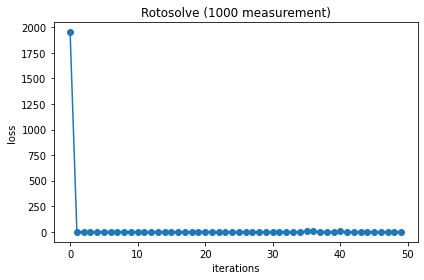

Learned parameters of the gates:  [tensor(-1.54834303, requires_grad=True), tensor(-3.04948454, requires_grad=True), tensor(-1.04461692, requires_grad=True), tensor(-1.06602701, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (0.01707318258797874+0j)	\prob_0 = 0.00029149356368246045
\psi_1 = (-0.7384989311135223+0j)	\prob_1 = 0.5453806712558149
\psi_2 = -0.6740373475259798j	\prob_2 = 0.4543263458598584
\psi_3 = 0.0012203772548753378j	\prob_3 = 1.4893206442170651e-06
--------------------------------------------------------------------------------


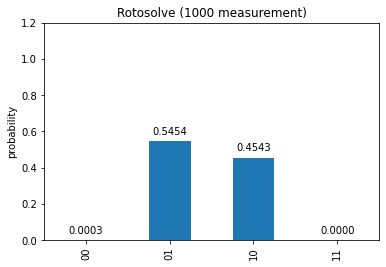

The standard deviation of loss after 10 iterations is: 1.5332910873660208
The mean squared error of the probabilities is: 0.0020727440030708084


In [163]:
# 1000 measurement per step
params_rsol, costs = fit(50, 1000)
plot_loss(50, costs, "Rotosolve (1000 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
probs = peek(dev)
plot_probs(probs, "Rotosolve (1000 measurement)")
metricx = report_metric(costs, dev)
metrics.append(metricx)

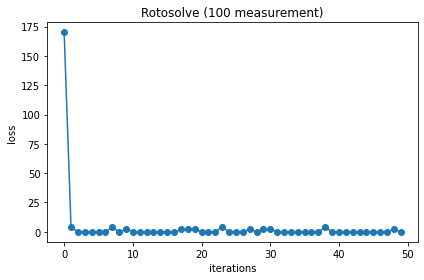

Learned parameters of the gates:  [tensor(-0.78539816, requires_grad=True), tensor(-2.81279996, requires_grad=True), tensor(-0.5203553, requires_grad=True), tensor(-0.42019671, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.013687363754675552+0j)	\prob_0 = 0.00018734392655280602
\psi_1 = (-0.9322990315708292+0j)	\prob_1 = 0.8691814842679059
\psi_2 = -0.359465703750828j	\prob_2 = 0.12921559217307801
\psi_3 = -0.03762418945921847j	\prob_3 = 0.0014155796324631664
--------------------------------------------------------------------------------


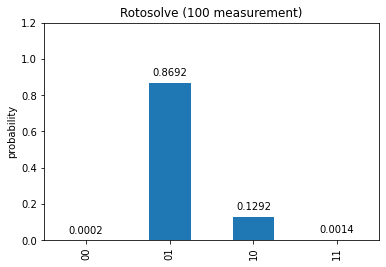

The standard deviation of loss after 10 iterations is: 1.1037764389253426
The mean squared error of the probabilities is: 0.13688802270690764


In [164]:
# 100 measurement per step
params_rsol, costs = fit(50, 100)
plot_loss(50, costs, "Rotosolve (100 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
probs = peek(dev)
plot_probs(probs, "Rotosolve (100 measurement)")
metricx = report_metric(costs, dev)
metrics.append(metricx)

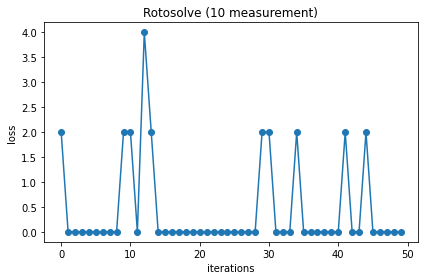

Learned parameters of the gates:  [tensor(-0.64350111, requires_grad=True), tensor(2.35619449, requires_grad=True), tensor(0.92729522, requires_grad=True), tensor(0.5880026, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.004324373225115301+0j)	\prob_0 = 1.8700203790094108e-05
\psi_1 = (0.9749210730178406+0j)	\prob_1 = 0.9504710986142577
\psi_2 = 0.21779109218886678j	\prob_2 = 0.047432959836819465
\psi_3 = -0.04557676321474141j	\prob_3 = 0.0020772413451326057
--------------------------------------------------------------------------------


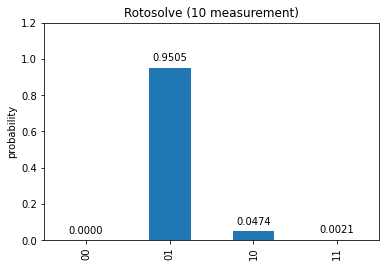

The standard deviation of loss after 10 iterations is: 0.9658043840596746
The mean squared error of the probabilities is: 0.2038705682643991


In [165]:
# 10 measurement per step
params_rsol, costs = fit(50, 10)
plot_loss(50, costs, "Rotosolve (10 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
probs = peek(dev)
plot_probs(probs, "Rotosolve (10 measurement)")
metricx = report_metric(costs, dev)
metrics.append(metricx)

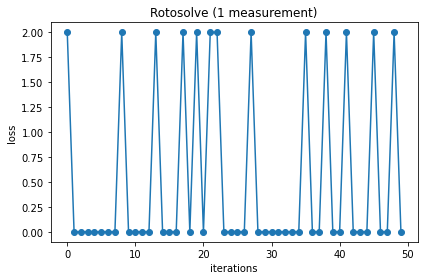

Learned parameters of the gates:  [tensor(2.35619449, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(0., requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (5.551115123125783e-17+0j)	\prob_0 = 3.0814879110195774e-33
\psi_1 = (-0.38268343236508984+0j)	\prob_1 = 0.1464466094067263
\psi_2 = 0j	\prob_2 = 0.0
\psi_3 = -0.9238795325112867j	\prob_3 = 0.8535533905932737
--------------------------------------------------------------------------------


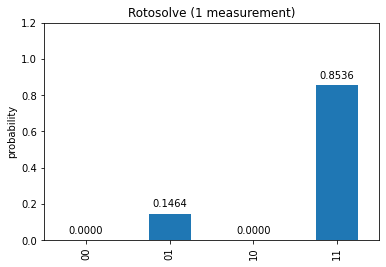

The standard deviation of loss after 10 iterations is: 0.8861415670529244
The mean squared error of the probabilities is: 0.1875


In [166]:
# Now we explore how the number of measurements can affect our algorithm
# 1 measurement per step
params_rsol, costs = fit(50, 1)
plot_loss(50, costs, "Rotosolve (1 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
probs = peek(dev)
plot_probs(probs, "Rotosolve (1 measurement)")
metricx = report_metric(costs, dev)
metrics.append(metricx)

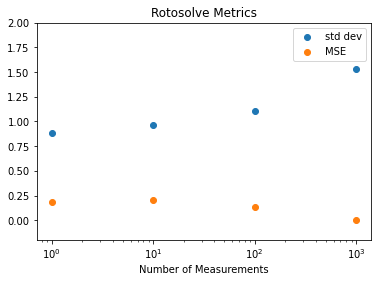

In [167]:
# Now we compare the performance across models with different measurements
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set(ylim=(-0.2,2))
ax.scatter([1,10,100,1000],np.array(metrics)[:,0][::-1], label="std dev")
ax.scatter([1,10,100,1000],np.array(metrics)[:,1][::-1], label="MSE")
ax.legend(loc="upper right")
ax.set_title("Rotosolve Metrics")
ax.set_xlabel("Number of Measurements")
plt.show()

The more mesurements taken per iteration during the optimization, the more accurate the result would be as the lower MSE suggests. On the other hand, thre more measurements, the higher the standard deviation of loss after 10 iterations would be, mostly becuase the range of the loss functions are exponentially different. The more measurements, the larger the range would be. However, looking at the loss plots, we can see that the Rotosolve is generally very stable after a few iterations with measurements larger than 100.

### Rotoselect
Rotoselect builds on the Rotosolve algorithm, now the choice of the parametric gates themselves (Rx, Ry in our case) can also be optimized.

In [168]:
def rotosolve(d, params, generators, cost, M_0):  # M_0 only calculated once
    params[d] = np.pi / 2.0
    M_0_plus = cost(params, generators)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params, generators)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi
    return cost(params, generators)


def optimal_theta_and_gen_helper(d, params, generators, cost):
    params[d] = 0.0
    M_0 = cost(params, generators)  # M_0 independent of generator selection
    for generator in ["X", "Y"]:
        generators[d] = generator
        params_cost = rotosolve(d, params, generators, cost, M_0)
        # initialize optimal generator with first item in list, "X", and update if necessary
        if generator == "X" or params_cost <= params_opt_cost:
            params_opt_d = params[d]
            params_opt_cost = params_cost
            generators_opt_d = generator
    return params_opt_d, generators_opt_d


def rotoselect_cycle(cost, params, generators):
    for d in range(len(params)):
        params[d], generators[d] = optimal_theta_and_gen_helper(d, params, generators, cost)
    return params, generators

In [169]:
def RGen(param, generator, wires):
    if generator == "X":
        qml.RX(param, wires=wires)
    elif generator == "Y":
        qml.RY(param, wires=wires)

def ansatz_rsel(params, generators):
    RGen(params[0], generators[0], wires=0)
    RGen(params[1], generators[1], wires=1)
    qml.CNOT(wires=[0, 1])
    RGen(params[2], generators[2], wires=0)
    RGen(params[3], generators[3], wires=1)

@qml.qnode(dev)
def circuit_rsel(params, generators=None):  # generators will be passed as a keyword arg
    ansatz_rsel(params, generators)
    #return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1))
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)) 

def cost_rsel(params, generators):
    m = circuit_rsel(params, generators=generators)
    #return np.abs(m[0] + m[1])
    return np.sum(np.abs(m[0] + m[1]))

In [170]:
def fit_select(n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    # initial parameters are randomly chosen according to a normal curve
    init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
    params_rsel = init_params.copy()
    costs_rsel = []
    generators = ["X", "Y", "Y", "X"]

    for i in range(n_steps):
        costs_rsel.append(cost_rsel(params_rsel, generators))
        params_rsel, generators = rotoselect_cycle(cost_rsel, params_rsel, generators)
    
    return params_rsel, costs_rsel, generators

In [172]:
np.random.seed(10)
metrics_rsel = []

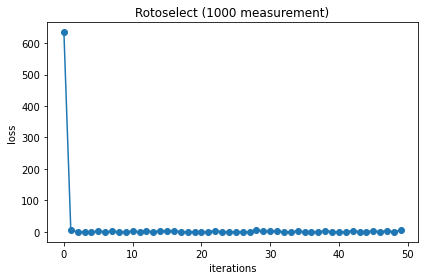

Learned generators:  ['X', 'X', 'Y', 'X']
Learned parameters of the gates:  [tensor(1.35125249, requires_grad=True), tensor(-3.12179326, requires_grad=True), tensor(0.31919791, requires_grad=True), tensor(0.29116736, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.09175367573518574+0.005860773937444473j)	\prob_0 = 0.008453085682063443
\psi_1 = (0.0006971761272804726+0.7713223823528501j)	\prob_1 = 0.5949387035730288
\psi_2 = (0.6186176604819706+0.0008957512880267363j)	\prob_2 = 0.3826886122305567
\psi_3 = (-0.004700470704267786+0.11788767573206917j)	\prob_3 = 0.013919598514351168
--------------------------------------------------------------------------------


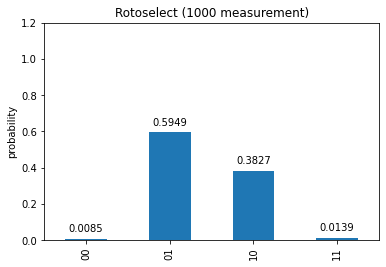

The standard deviation of loss after 10 iterations is: 1.8536585365853657
The mean squared error of the probabilities is: 0.011387659568260058


In [173]:
# 1000 measurement per step
params_rsel, costs, generators = fit_select(50, 1000)
plot_loss(50, costs, "Rotoselect (1000 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
probs = peek(dev)
plot_probs(probs, "Rotoselect (1000 measurement)")
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

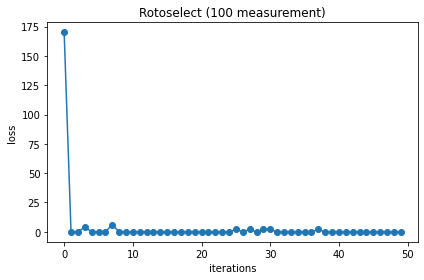

Learned generators:  ['Y', 'X', 'Y', 'Y']
Learned parameters of the gates:  [tensor(0.32175055, requires_grad=True), tensor(-3.10457254, requires_grad=True), tensor(0.06512516, requires_grad=True), tensor(-0.01999733, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (0.01825843964929379+0.004648600977424973j)	\prob_0 = 0.00035498010947422
\psi_1 = (-0.00027909588172456173+0.9863980114483903j)	\prob_1 = 0.9729811148838499
\psi_2 = (0.0006244115662974318+0.1603831623148141j)	\prob_2 = 0.02572314864390413
\psi_3 = (0.002957146238221221+0.030528865830509844j)	\prob_3 = 0.0009407563627714973
--------------------------------------------------------------------------------


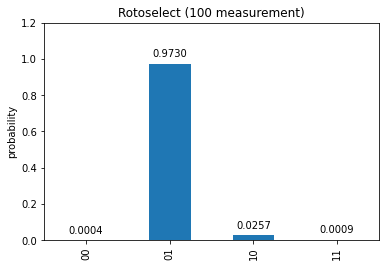

The standard deviation of loss after 10 iterations is: 0.6544589202438409
The mean squared error of the probabilities is: 0.22432483338451092


In [174]:
# 100 measurement per step
params_rsel, costs, generators = fit_select(50, 100)
plot_loss(50, costs, "Rotoselect (100 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
probs = peek(dev)
plot_probs(probs, "Rotoselect (100 measurement)")
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

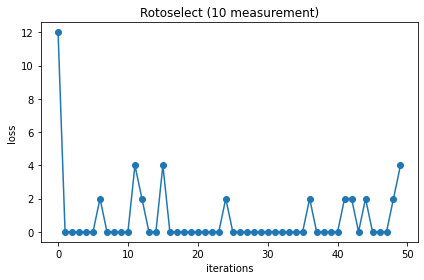

Learned generators:  ['Y', 'Y', 'Y', 'Y']
Learned parameters of the gates:  [tensor(0.32175055, requires_grad=True), tensor(0.26625205, requires_grad=True), tensor(3.14159265, requires_grad=True), tensor(-0.32175055, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.046418274924777195+0j)	\prob_0 = 0.0021546562469921993
\psi_1 = (-0.15330914756710023+0j)	\prob_1 = 0.023503694727750917
\psi_2 = (0.9867074429773395+0j)	\prob_2 = 0.9735915780268797
\psi_3 = (-0.02738742409167852+0j)	\prob_3 = 0.000750070998377453
--------------------------------------------------------------------------------


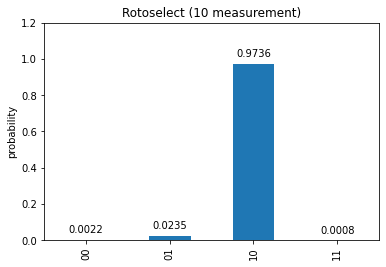

The standard deviation of loss after 10 iterations is: 1.204789174168631
The mean squared error of the probabilities is: 0.22566885585804722


In [175]:
# 10 measurement per step
params_rsel, costs, generators = fit_select(50, 10)
plot_loss(50, costs, "Rotoselect (10 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
probs = peek(dev)
plot_probs(probs, "Rotoselect (10 measurement)")
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

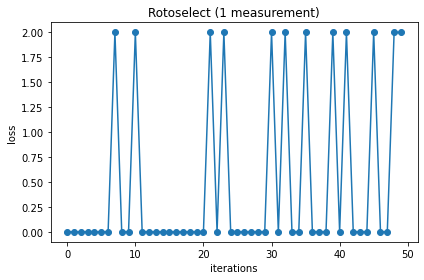

Learned generators:  ['Y', 'X', 'Y', 'Y']
Learned parameters of the gates:  [tensor(-2.35619449, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(2.35619449, requires_grad=True), tensor(0.78539816, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.13529902503654923+0.5179824574016388j)	\prob_0 = 0.28661165235168135
\psi_1 = (0.5972387912921926+0.3266407412190941j)	\prob_1 = 0.46338834764831843
\psi_2 = (0.3266407412190942-0.32664074121909414j)	\prob_2 = 0.2133883476483185
\psi_3 = (-0.13529902503654928+0.13529902503654923j)	\prob_3 = 0.03661165235168156
--------------------------------------------------------------------------------


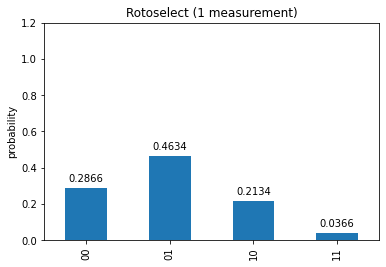

The standard deviation of loss after 10 iterations is: 0.8861415670529244
The mean squared error of the probabilities is: 0.04174332617584077


In [176]:
# 1 measurement per step
params_rsel, costs, generators = fit_select(50, 1)
plot_loss(50, costs, "Rotoselect (1 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
probs = peek(dev)
plot_probs(probs, "Rotoselect (1 measurement)")
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

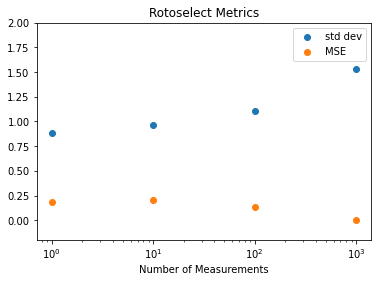

In [177]:
# Now we compare the performance across models with different measurements
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set(ylim=(-0.2,2))
ax.scatter([1,10,100,1000],np.array(metrics)[:,0][::-1], label="std dev")
ax.scatter([1,10,100,1000],np.array(metrics)[:,1][::-1], label="MSE")
ax.legend(loc="upper right")
ax.set_title("Rotoselect Metrics")
ax.set_xlabel("Number of Measurements")
plt.show()

Rotoselect's metrics behave similarly as Rotosolve's with respect to the numebr of measurements. Also note that Rotoselect's performance is about the same as Rotosolve's probably because that the circuit is simple. In fact in Fig.2 in the original paper [1], when working on VQE to minimize the energy, the Rotoseletct performs consistently better when the number of layers in the circuit is larger than 4.

### QGAN 
A quantum Generative Adversarial Network (qGAN) can learn the distribution of a particular smaple and load it into a quantum state.  

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$. In our general two qubit system:

$$\big|\psi\rangle=\alpha\big|00\rangle+\beta\big|01\rangle+\gamma\big|10\rangle+\delta\big|11\rangle$$

where $\big| j\rangle\in \left\{\big|00\rangle, \big|01\rangle, \big|10\rangle, \big|11\rangle\right\}$.

So our goal is to train a quantum generator that can generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j} = 0.5$ if $\big| j\rangle \in \left\{\big|01\rangle, \big|10\rangle\right\}$.

As a result, the training data should follow a bimodal distribution where the two peaks is around $\big|01\rangle, \big|10\rangle$. It is worth noting that a GAN is well suited for generate both uni-modal and multi-modal distributions.

In [3]:
import time
from torch import optim
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.circuit.library import TwoLocal

from qiskit.aqua.algorithms import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks import NumPyDiscriminator

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer

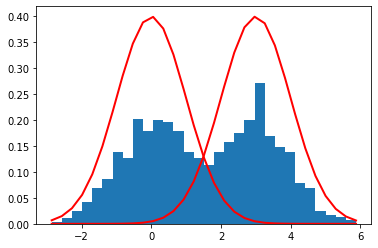

In [6]:
# First load the training data. As mentioned above, we chose a bi-modal distribution.

# Number training data samples
N = 1000 

# Load data samples from a bi-modal distribution contructed from 2 normal distribution
mu1 = 0
mu2 = 3
sigma = 1

real_data1 = np.random.normal(mu1, sigma, size=N//2)
real_data2 = np.random.normal(mu2, sigma, size=N//2)

real_data = np.concatenate([real_data1, real_data2])

count, bins, ignored = plt.hist(real_data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu1)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu2)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [7]:
# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

In [8]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, 
            num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits), 
                                low=bounds[0], high=bounds[1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
init_dist.build(qc, q)
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
var_form = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cx', 
                    entanglement=entangler_map,
                    reps=1, initial_state=init_distribution)
# Set generator's initial parameters
init_params = np.random.rand(var_form.num_parameters_settable)*2*np.pi
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), 
                                              var_form, init_params,
                                              low=bounds[0], high=bounds[1])
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [179]:
print(var_form)

     ┌──────────┐┌──────────┐     ┌──────────┐
q_0: ┤ U2(0,pi) ├┤ RY(θ[0]) ├──■──┤ RY(θ[2]) ├
     ├──────────┤├──────────┤┌─┴─┐├──────────┤
q_1: ┤ U2(0,pi) ├┤ RY(θ[1]) ├┤ X ├┤ RY(θ[3]) ├
     └──────────┘└──────────┘└───┘└──────────┘


In [9]:
# Run qGAN
start = time.time()
qgan.run(quantum_instance)

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  32.32887662649155  min


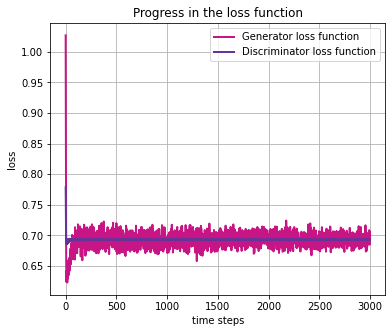

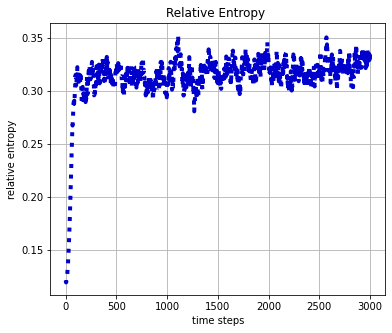

In [11]:
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

In [141]:
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=100000)

In [142]:
print(samples_g, prob_g)

[[0.0], [1.0], [2.0], [3.0]] [0.04197282008190514, 0.44224977683349587, 0.4976293501331209, 0.018148052951478078]


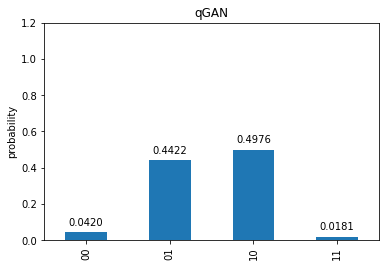

In [178]:
plot_probs(prob_g, "qGAN")

In [103]:
p_b, p_r = abs(prob_g[1])**2, abs(prob_g[2])**2
mse = 1/2*((p_b-0.5)**2 + (p_r-0.5)**2)
print("The mean squared error of the probabilities is: {}".format(mse))

The mean squared error of the probabilities is: 0.07817834132997156
